### Within session units: 
If doing within-session analysis, what is a feature/session pair with the most simauteneously recorded units?

In [16]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *
from constants.decoding_constants import *
import seaborn as sns
from scripts.anova_analysis.anova_configs import *
from scripts.anova_analysis.run_anova import load_data
from scripts.pseudo_decoding.single_selected_feature_configs import *

from scipy import stats
import argparse
import copy
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import itertools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load results for inter-trial interval first (1s prior to stim onset)

In [2]:
args = argparse.Namespace(
    **AnovaConfigs()._asdict()
)
args.trial_event = "StimOnset"
args.conditions = ["FeatPreferred"]
# args.conditions = ["Response", "Choice"]
args.time_range = [-1000, 0]
args.beh_filters = {"Response":"Correct","Choice":"Chose","PreferredChosen":True}
res = io_utils.read_anova_good_units(args, "95th")
res["session"] = (res.PseudoUnitID / 100).astype(int)

In [3]:
grouped = res.groupby(["feat", "session"]).PseudoUnitID.nunique().reset_index(name="num_units")

In [4]:
grouped.sort_values(by="num_units", ascending=False)[:20]

,feat,session,num_units
136,SWIRL,20180615,8
0,CIRCLE,20180615,6
165,YELLOW,20180907,6
117,SQUARE,20180919,6
129,STAR,20180919,6
28,CYAN,20180912,6
56,GREEN,20180904,6
67,MAGENTA,20180803,5
146,SWIRL,20180904,5
93,RIPPLE,20180615,5


Looks like 20180615 for SWIRL, CIRCLE and 20180919 for SQUARE, STAR could be good candidates

### Plot what the example units look like, firing rate wise

In [5]:
session = 20180615
feat = "SWIRL"
args.feat = feat
data = load_data(session, args)
sess_feat_res = res[(res.feat == feat) & (res.session == session)]

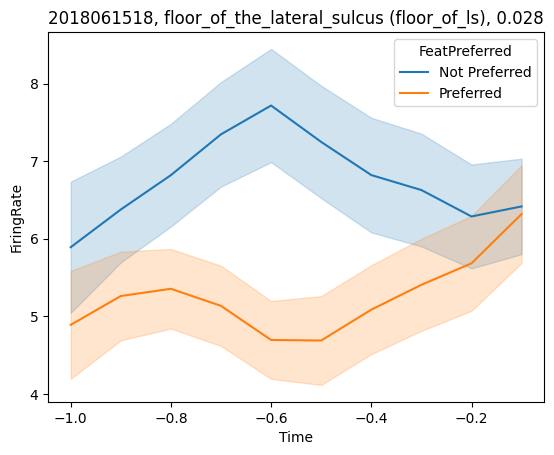

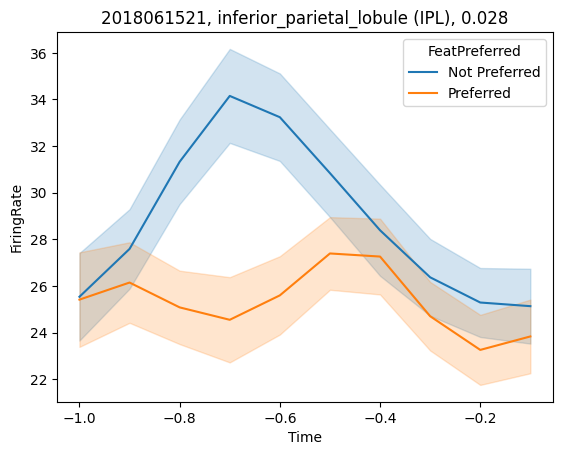

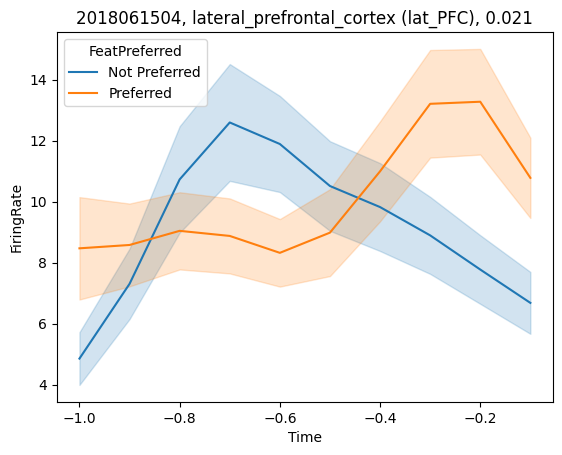

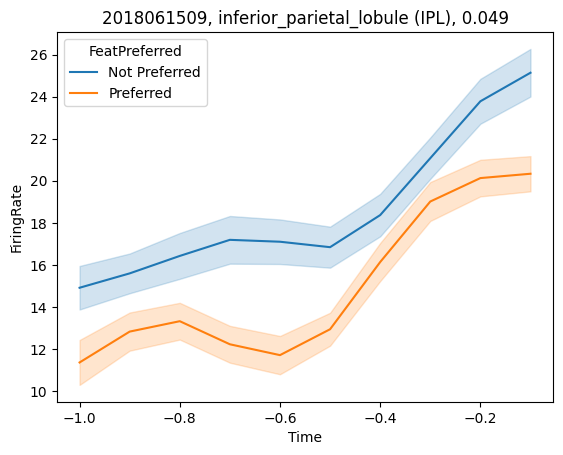

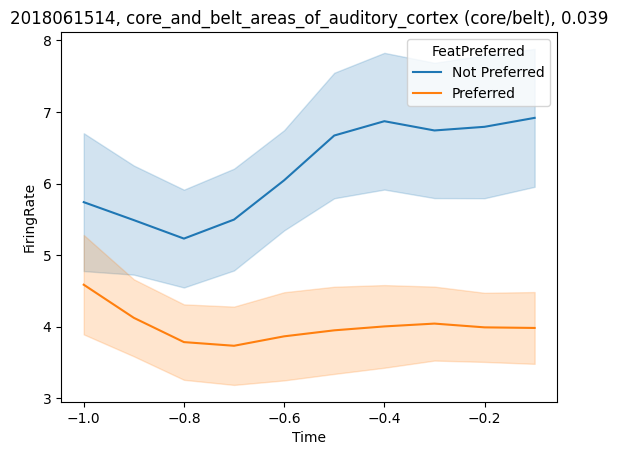

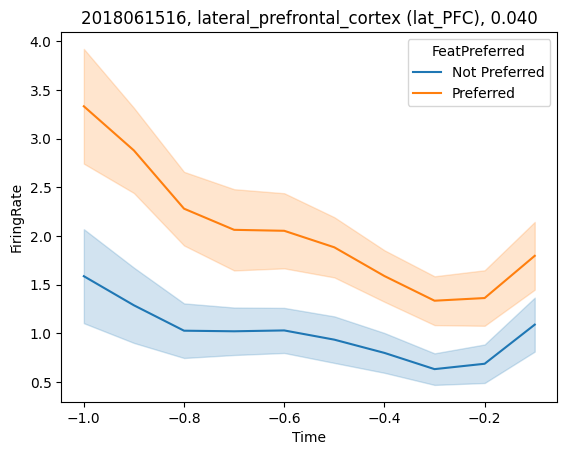

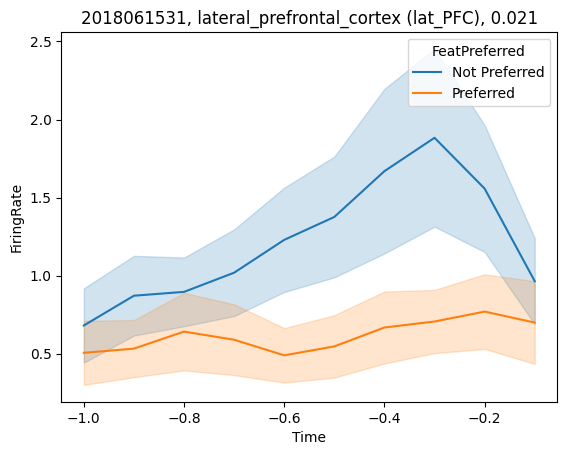

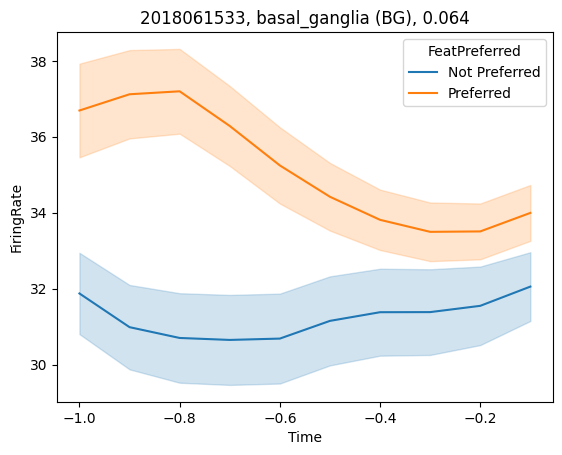

In [6]:
for i, row in sess_feat_res.iterrows():
    unit_id = row.PseudoUnitID
    unit_data = data[data.PseudoUnitID == unit_id]
    order = np.sort(unit_data["FeatPreferred"].unique())
    fig, ax = plt.subplots()
    sns.lineplot(unit_data, x="Time", y="FiringRate", hue="FeatPreferred", hue_order=order, errorbar="se", ax=ax)
    ax.set_title(f"{unit_id}, {row.structure_level2}, {row.combined_fracvar:.3f}")


### See what the decoder weights for these 8 units look like

In [7]:
args = argparse.Namespace(
    **SingleSelectedFeatureConfigs()._asdict()
)
args.beh_filters = {"Response": "Correct", "PreferredChosen": True}
args.shuffle_method = "session_permute"
args.sig_unit_level = "95th"
weights = io_utils.get_selected_features_weights_with_ids(args, FEATURES, "pref_vs_not_pref")



In [8]:
sess_feat_res

,PseudoUnitID,total_var,x_TimeBins_fracvar,x_FeatPreferred_fracvar,x_TimeBinsFeatPreferred_fracvar,residual_fracvar,sum_fracvar,combined_fracvar,feat,95th,99th,drive,structure_level2,session
69,2018061518,26.578051,0.002422,0.021253,0.006813,0.969512,1.0,0.028066,SWIRL,0.021196,0.039465,Temporal,floor_of_the_lateral_sulcus (floor_of_ls),20180615
165,2018061521,193.665702,0.017988,0.015461,0.012062,0.954489,1.0,0.027523,SWIRL,0.022686,0.027326,Temporal,inferior_parietal_lobule (IPL),20180615
418,2018061504,132.125063,0.012941,0.001697,0.019771,0.965591,1.0,0.021468,SWIRL,0.021390,0.025787,Anterior,lateral_prefrontal_cortex (lat_PFC),20180615
419,2018061509,73.198318,0.150947,0.045414,0.004032,0.799607,1.0,0.049446,SWIRL,0.034441,0.046667,Temporal,inferior_parietal_lobule (IPL),20180615
420,2018061514,33.623868,0.003252,0.035734,0.003283,0.957731,1.0,0.039017,SWIRL,0.025101,0.066352,Temporal,core_and_belt_areas_of_auditory_cortex (core/b...,20180615
421,2018061516,7.606001,0.025269,0.036052,0.004187,0.934492,1.0,0.040239,SWIRL,0.029989,0.047919,Anterior,lateral_prefrontal_cortex (lat_PFC),20180615
422,2018061531,5.681280,0.007831,0.015840,0.004889,0.971439,1.0,0.020729,SWIRL,0.019493,0.023835,Anterior,lateral_prefrontal_cortex (lat_PFC),20180615
423,2018061533,72.001370,0.006235,0.053755,0.010185,0.929825,1.0,0.063940,SWIRL,0.045236,0.051536,Temporal,basal_ganglia (BG),20180615


In [9]:
sess_feat_weights = weights[weights.PseudoUnitID.isin(sess_feat_res.PseudoUnitID) & (weights.feat == feat)]
sess_feat_weights = sess_feat_weights[sess_feat_weights.Time < 0]
proj_weights = sess_feat_weights.groupby(["PseudoUnitID", "Time"]).weight.mean().reset_index(name="weight")
proj_weights["weight"] = proj_weights["weight"] / np.sqrt(np.sum(proj_weights["weight"] ** 2))

### Load data

In [21]:
args = argparse.Namespace(
    **AnovaConfigs()._asdict()
)
args.trial_event = "StimOnset"
args.conditions = ["FeatPreferred"]
args.beh_filters = {"Response":"Correct","Choice":"Chose","PreferredChosen":True}
args.time_range = [-1000, 0]
args.feat = feat
args.trial_interval = get_trial_interval(args.trial_event)

data = load_data(session, args)
data = spike_utils.zscore_frs(data, ["PseudoUnitID"], "FiringRate")

/src/wcst_decode/utils/spike_utils.py:280: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  return frs.groupby(group_cols).apply(zscore_unit).reset_index(drop=True)


In [22]:
data

,TrialNumber,UnitID,TimeBins,SpikeCounts,FiringRate,PseudoUnitID,Time,BlockNumber,TrialAfterRuleChange,TaskInterrupt,...,PreferredBelief,BeliefStateValueLabel,PreferredChosen,PrevResponse,PrevColor,PrevShape,PrevPattern,Choice,FeatPreferred,ZFiringRate
0,49,0,0.0,1.0,6.411826,2018061500,-1.0,2,4,NaN,...,TRIANGLE,Low,True,Incorrect,CYAN,CIRCLE,RIPPLE,Chose,Not Preferred,0.236708
1,49,0,0.1,0.0,3.049601,2018061500,-0.9,2,4,NaN,...,TRIANGLE,Low,True,Incorrect,CYAN,CIRCLE,RIPPLE,Chose,Not Preferred,-0.394237
2,49,0,0.2,0.0,1.708371,2018061500,-0.8,2,4,NaN,...,TRIANGLE,Low,True,Incorrect,CYAN,CIRCLE,RIPPLE,Chose,Not Preferred,-0.645928
3,49,0,0.3,0.0,5.427674,2018061500,-0.7,2,4,NaN,...,TRIANGLE,Low,True,Incorrect,CYAN,CIRCLE,RIPPLE,Chose,Not Preferred,0.052025
4,49,0,0.4,2.0,10.488559,2018061500,-0.6,2,4,NaN,...,TRIANGLE,Low,True,Incorrect,CYAN,CIRCLE,RIPPLE,Chose,Not Preferred,1.001735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49135,711,38,0.5,0.0,2.465371,2018061538,-0.5,30,20,NaN,...,SWIRL,High SWIRL,True,Correct,GREEN,SQUARE,SWIRL,Chose,Preferred,-0.275659
49136,711,38,0.6,0.0,0.585568,2018061538,-0.4,30,20,NaN,...,SWIRL,High SWIRL,True,Correct,GREEN,SQUARE,SWIRL,Chose,Preferred,-1.372881
49137,711,38,0.7,0.0,0.584230,2018061538,-0.3,30,20,NaN,...,SWIRL,High SWIRL,True,Correct,GREEN,SQUARE,SWIRL,Chose,Preferred,-1.373662
49138,711,38,0.8,0.0,2.421053,2018061538,-0.2,30,20,NaN,...,SWIRL,High SWIRL,True,Correct,GREEN,SQUARE,SWIRL,Chose,Preferred,-0.301527


In [23]:
def project_mean_firing(trial_data, proj_weights, column):
    """
    Return projection, column of interest
    """
    # mean_firing = trial_data.groupby("PseudoUnitID").ZFiringRate.mean().reset_index(name="MeanZFiringRate")
    merged = pd.merge(trial_data, proj_weights, on=["PseudoUnitID", "Time"])
    proj = np.sum(merged.ZFiringRate * merged.weight) / merged.Time.nunique()
    return pd.Series({"proj": proj, column: trial_data.iloc[0][column]})

res = data.groupby("TrialNumber").apply(lambda x: project_mean_firing(x, proj_weights, f"{feat}Prob")).reset_index()

In [24]:
# res = data.groupby("TrialNumber").apply(lambda x: project_mean_firing(x, proj_weights, "Choice")).reset_index()

In [25]:
res

,TrialNumber,proj,SWIRLProb
0,49,-0.523394,0.064052
1,54,-0.730212,0.018580
2,55,-0.173907,0.041446
3,57,-0.214575,0.035998
4,72,-0.418434,0.036256
...,...,...,...
121,707,0.809689,0.578520
122,708,0.170816,0.651717
123,709,-0.093920,0.683049
124,710,0.277804,0.698726


Text(0.5, 1.0, 'r: 0.443, p: 2.048E-07')

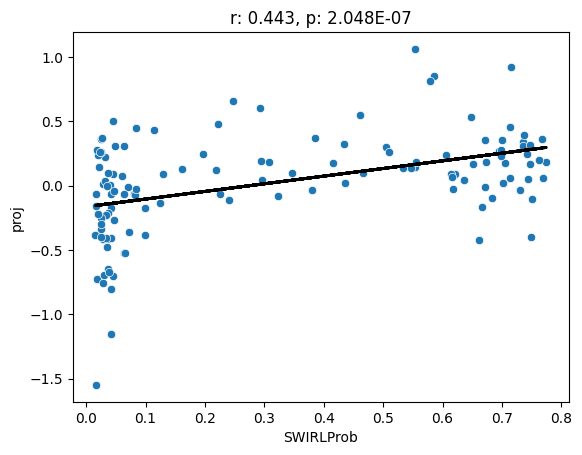

In [26]:
fig, ax = plt.subplots()
sns.scatterplot(res, x=f"{feat}Prob", y="proj", ax=ax)
slope, intercept, r_value, p_value, std_err = stats.linregress(res[f"{feat}Prob"], res["proj"])
ax.plot(res[f"{feat}Prob"], res[f"{feat}Prob"] * slope + intercept, color="black", linewidth=2)
ax.set_title(f"r: {r_value:.3f}, p: {p_value:.3E}")